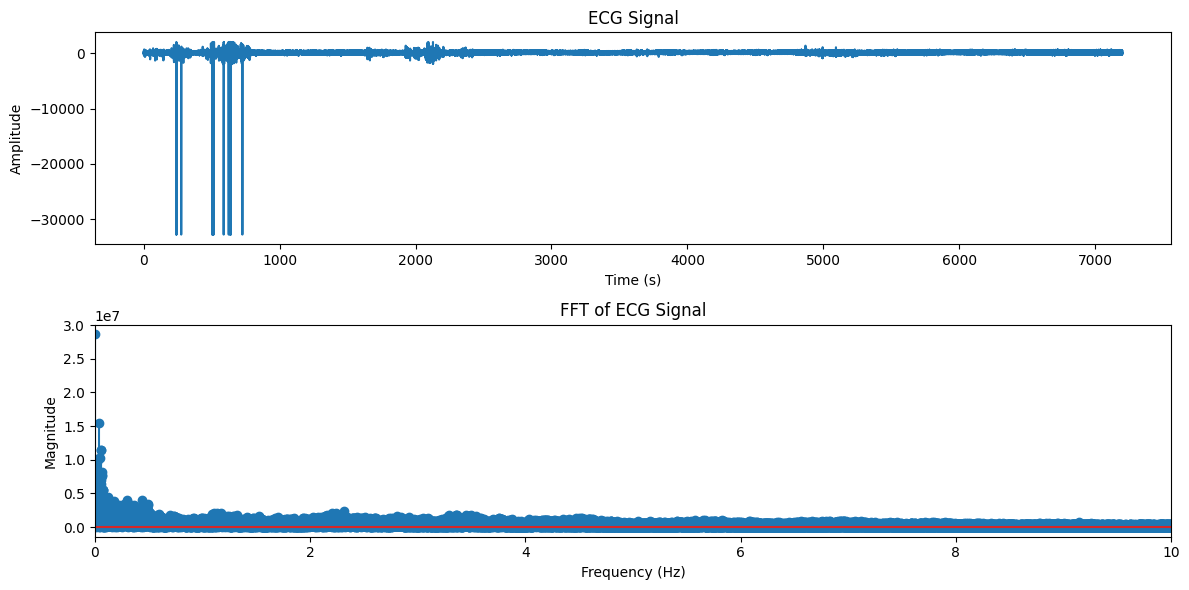

Major Frequency Components (≤ cutoff):


,Frequency (Hz),Magnitude
0,0.000417,2.652173e+06
1,0.002083,1.599507e+06
2,0.002500,1.569935e+06
3,0.005000,1.313744e+06
4,0.005278,1.293594e+06
...,...,...
206638,-0.005278,1.293594e+06
206639,-0.005000,1.313744e+06
206640,-0.002500,1.569935e+06
206641,-0.002083,1.599507e+06


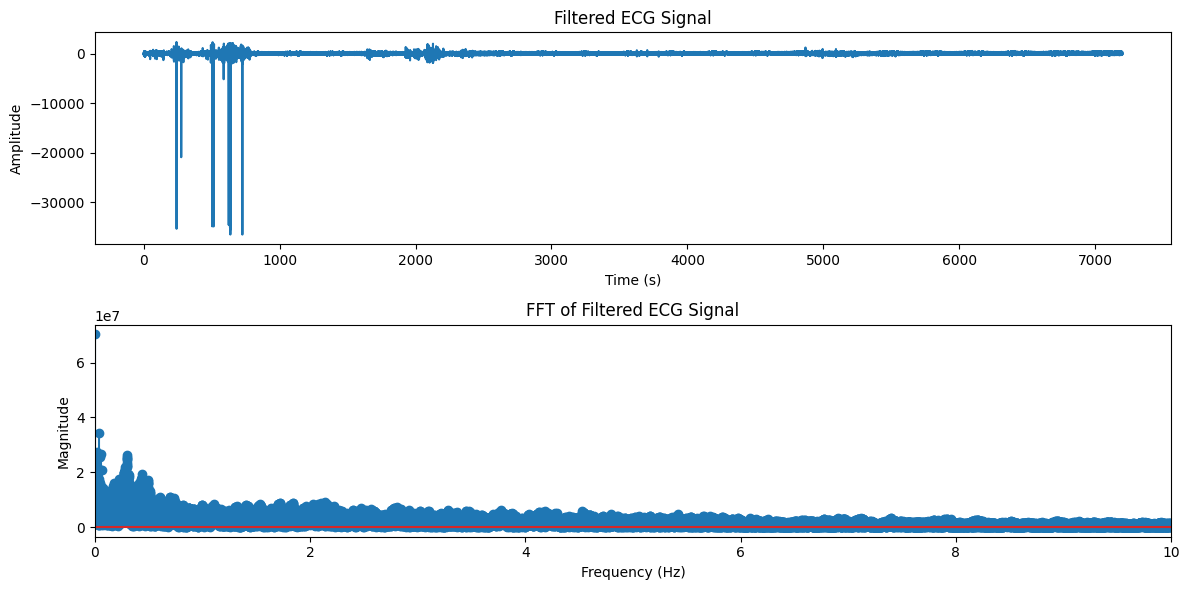

,MNF,PMNF,MDF,PMDF,PKF,PPKF,PBAND,Entropy,SM1,SM2,SM3,Energy(dB),Power(dB)
0,2.963766,2.963766,1.953125,1.953125,0.976562,0.976562,14832.222193,2.975027,43959.237246,226269.427311,1.599080e+06,121.738159,82.987546
1,2.643735,2.643735,1.953125,1.953125,0.976562,0.976562,19603.246503,2.893102,51825.781021,233916.174205,1.461626e+06,124.655902,85.905290
2,2.795740,2.795740,1.953125,1.953125,0.976562,0.976562,19403.628463,2.885009,54247.509121,261935.110823,1.773211e+06,123.634606,84.883993
3,3.543383,3.543383,2.929688,2.929688,0.976562,0.976562,21689.530252,3.218354,76854.302536,419804.731146,2.957026e+06,123.684360,84.933748
4,3.851163,3.851163,2.929688,2.929688,2.929688,2.929688,20977.610358,3.297863,80788.198558,463962.387454,3.364823e+06,123.103407,84.352795
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,3.797390,3.797390,2.929688,2.929688,1.953125,1.953125,12710.562395,3.200748,48266.959455,271829.370976,1.961348e+06,119.038166,80.287553
236,3.586861,3.586861,2.929688,2.929688,1.953125,1.953125,12844.372762,3.065506,46070.973903,247842.536086,1.746907e+06,121.775923,83.025310
237,3.579466,3.579466,2.929688,2.929688,1.953125,1.953125,12810.184961,3.164154,45853.615955,252122.907654,1.804235e+06,119.845881,81.095269
238,3.710651,3.710651,2.929688,2.929688,1.953125,1.953125,14966.449442,3.167130,55535.269060,309087.647747,2.221754e+06,119.336289,80.585677


In [1]:
# ============================================
# FULL ECG MATLAB → PYTHON CONVERSION
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import loadmat
from scipy.signal import butter, filtfilt, windows, find_peaks, welch
from scipy.fft import fft, fftfreq
from antropy import spectral_entropy

# ============================================
# Load ECG Data
# ============================================

data = loadmat('/home/nirjhar/Python Codes/Fourier/FFT-based-ECG-data-analysis/Sudden cardiac arrest testing signal-20251227T175333Z-3-001/Sudden cardiac arrest testing signal/test1mat.mat')      # upload this file to Colab
ECG_signal = data['fdata1'].squeeze().astype(float)

fs = 250                       # sampling frequency
cutoff_freq = 12.5

t = np.arange(len(ECG_signal)) / fs

# ============================================
# Plot ECG Signal (Time Domain)
# ============================================

plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(t, ECG_signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG Signal")

# ============================================
# FFT with Hamming Window
# ============================================

win = windows.hamming(len(ECG_signal))
data_windowed = ECG_signal * win

N = len(data_windowed)
Y = fft(data_windowed)
f = fftfreq(N, 1/fs)

plt.subplot(2,1,2)
plt.stem(f[f>=0], np.abs(Y[f>=0]))
plt.xlim(0,10)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT of ECG Signal")

plt.tight_layout()
plt.show()

# ============================================
# Peak Detection in FFT
# ============================================

threshold = np.max(np.abs(Y)) * 0.0005
peaks, _ = find_peaks(np.abs(Y), height=threshold)

major_freqs = f[peaks]
major_mags = np.abs(Y[peaks])

mask = major_freqs <= cutoff_freq
major_freqs = major_freqs[mask]
major_mags = major_mags[mask]

table = pd.DataFrame({
    "Frequency (Hz)": major_freqs,
    "Magnitude": major_mags
})

print("Major Frequency Components (≤ cutoff):")
display(table)

# ============================================
# Low-pass Butterworth Filter
# ============================================

order = 4
b, a = butter(order, cutoff_freq/(fs/2), btype='low')
filtered_signal = filtfilt(b, a, ECG_signal)

# ============================================
# Plot Filtered ECG + FFT
# ============================================

plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(t, filtered_signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Filtered ECG Signal")

Yf = fft(filtered_signal)

plt.subplot(2,1,2)
plt.stem(f[f>=0], np.abs(Yf[f>=0]))
plt.xlim(0,10)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT of Filtered ECG Signal")

plt.tight_layout()
plt.show()

# ============================================
# Spectral Feature Functions
# ============================================

def mnf(x, fs):
    f, P = welch(x, fs)
    return np.sum(f * P) / np.sum(P)

def pmnf(x, fs):
    f, P = welch(x, fs)
    P = P / np.sum(P)
    return np.sum(f * P)

def mdf(x, fs):
    f, P = welch(x, fs)
    cumsum = np.cumsum(P)
    return f[np.where(cumsum >= cumsum[-1]/2)[0][0]]

def pmdf(x, fs):
    f, P = welch(x, fs)
    P = P / np.sum(P)
    cumsum = np.cumsum(P)
    return f[np.where(cumsum >= 0.5)[0][0]]

def pkf(x, fs):
    f, P = welch(x, fs)
    return f[np.argmax(P)]

def ppkf(x, fs):
    f, P = welch(x, fs)
    P = P / np.sum(P)
    return f[np.argmax(P)]

def pband(x, fs):
    _, P = welch(x, fs)
    return np.sum(P)

def entr(x, fs):
    return spectral_entropy(x, fs, method='welch')

def sm1(x, fs):
    f, P = welch(x, fs)
    return np.sum(f * P)

def sm2(x, fs):
    f, P = welch(x, fs)
    return np.sum((f**2) * P)

def sm3(x, fs):
    f, P = welch(x, fs)
    return np.sum((f**3) * P)

# ============================================
# 30-second Window Feature Extraction
# ============================================

sample_size = 30 * fs
n_bins = len(filtered_signal) // sample_size

spectral_parameter = np.zeros((n_bins, 13))

for i in range(n_bins):
    segment = filtered_signal[i*sample_size:(i+1)*sample_size]

    spectral_parameter[i,0]  = mnf(segment, fs)
    spectral_parameter[i,1]  = pmnf(segment, fs)
    spectral_parameter[i,2]  = mdf(segment, fs)
    spectral_parameter[i,3]  = pmdf(segment, fs)
    spectral_parameter[i,4]  = pkf(segment, fs)
    spectral_parameter[i,5]  = ppkf(segment, fs)
    spectral_parameter[i,6]  = pband(segment, fs)
    spectral_parameter[i,7]  = entr(segment, fs)
    spectral_parameter[i,8]  = sm1(segment, fs)
    spectral_parameter[i,9]  = sm2(segment, fs)
    spectral_parameter[i,10] = sm3(segment, fs)

    ECG_dft = fft(segment)
    ECG_mag = np.abs(ECG_dft)

    energy = np.sum(ECG_mag**2)
    power = energy / sample_size

    spectral_parameter[i,11] = 10 * np.log10(energy)
    spectral_parameter[i,12] = 10 * np.log10(power)

# ============================================
# Final Output
# ============================================

columns = [
    "MNF","PMNF","MDF","PMDF","PKF","PPKF",
    "PBAND","Entropy","SM1","SM2","SM3",
    "Energy(dB)","Power(dB)"
]

spectral_df = pd.DataFrame(spectral_parameter, columns=columns)
display(spectral_df)
